# Introductory Examples

> Quantitative analysis, as we define it, is the application of mathematical and/or statistical methods to market data.

> <div style="text-align: right">— Rem Koolhaas </div>

We will dives into some concrete examples from _quantitative finance_ to illustrate how convenient and powerful it is to use <code>Python</code> and its libraries for financial analytics.

The examples are:
* Implied volatilities
* Monte Carlo simulation
* Technical analysis

## Implied Volatilities

Given an option pricing formula like the seminal one of Black-Scholes-Merton (1973), _implied volatilities_ are those volatility values that when put into the formula, give observed market quotes for different option strikes and maturities. Let us first reproduce in Equation 3-1 the famous Black-Scholes-Merton formula for the pricing of European call options on an underlying without dividends.

**Equation 3-1**. _Black-Scholes-Merton (1973) option pricing formula_

$$ C(S_{t}, K, t, T, r, \sigma) = S_{t} \cdot N(d_{1}) - \exp^{-r(T-t)} \cdot K \cdot N(d_{2}) $$ 

$$ N(d) = \frac{1}{\sqrt{(2 \pi)}} \int_{-\infty}^{d}{\exp^{-\frac{1}{2}x^{2}}dx}  $$ 

$$ d_{1} = \frac{\log{\frac{S_{t}}{K}} + (r + \frac{\sigma_{2}}{2}) (T - t)}{\sigma \sqrt{T - t}} $$

$$ d_{2} = \frac{\log{\frac{S_{t}}{K}} + (r - \frac{\sigma_{2}}{2}) (T - t)}{\sigma \sqrt{T - t}} $$

$S_{t}$ = Price/level of the underlying at time t

$\sigma$ = Constant volatility (i.e., standard deviation of returns) of the underlying

$K$ = Strike price of the option

$T$ = Maturity date of the option

$r$ = Constant riskless short rate


Consider now that an option quote for a European call option C* is given. The implied volatility &sigma;<sup>imp</sup> is the quantity that solves the implicit Equation 3-2.

**Equation 3-2**. _Implied volatility given market quote for option_

$$ C(S_{T}, K, t, T, r, \sigma^{imp}) = C^{*} $$ 

There is no closed-form solution to this equation, such that one has to use a numerical solution procedure like the Newton scheme to estimate the correct solution.

**Equation 3-3**. _Newton scheme for numerically solving equations_

$$ \sigma_{n+1}^{imp} = \sigma_{n}^{imp} - \frac{C(\sigma_{n}^{imp}) - C^{*}}
{\partial C(\sigma_{n}^{imp})/\partial \sigma_{n}^{imp}} $$

The partial derivative of the option pricing formula with respect to the volatility is called Vega and is given in closed form by Equation 3-4.

**Equation 3-4**. _Vega of a European option in BSM model_

$$ \frac{\partial C}{\partial \sigma} = S_{t} N(d_{1})\sqrt{T -t} $$

**Example 3-1**. _Black-Scholes-Merton (1973) functions_

Let us start with the day from which the quotes are taken; i.e., our t = 0 reference day. This is March 31, 2014. At this day, the closing value of the index was V<sub>0</sub> = 17.6639.

In [1]:
V0 = 17.6639

For the risk-free short rate, we assume a value of r = 0.01 p.a.:

In [2]:
r = 0.01

All other input parameters are given by the options data (i.e., T and K) or have to be calculated (i.e., &sigma;<sup>imp</sup>). The data is stored in a <code>pandas DataFrame</code> object and saved in a <code>PyTables</code> database file. 

In [3]:
import pandas as pd

h5 = pd.HDFStore('vstoxx_data_31032014.h5', 'r') 
futures_data = h5['futures_data'] # VSTOXX futures data 
options_data = h5['options_data'] # VSTOXX call option data 
h5.close()

In [4]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,1396224000000000000,2014,4,17.85,1397779200000000000,0.049
497,1396224000000000000,2014,5,19.55,1400198400000000000,0.126
498,1396224000000000000,2014,6,19.95,1403222400000000000,0.222
499,1396224000000000000,2014,7,20.40,1405641600000000000,0.299
500,1396224000000000000,2014,8,20.70,1408060800000000000,0.375
501,1396224000000000000,2014,9,20.95,1411084800000000000,0.471
502,1396224000000000000,2014,10,21.05,1413504000000000000,0.548
503,1396224000000000000,2014,11,21.25,1416528000000000000,0.644


In [5]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null int64
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null int64
TTM          395 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 27.8+ KB


In [6]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,1396224000000000000,1397779200000000000,0.049,1.0,16.85
46171,1396224000000000000,1397779200000000000,0.049,2.0,15.85
46172,1396224000000000000,1397779200000000000,0.049,3.0,14.85
46173,1396224000000000000,1397779200000000000,0.049,4.0,13.85
46174,1396224000000000000,1397779200000000000,0.049,5.0,12.85


In [7]:
options_data['IMP_VOL'] = 0.0 # new column for implied volatilities

In [8]:
from bsm_functions import *

In [9]:
tol = 0.5 # tolerance level for moneyness

for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                           options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE'] 
        < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        imp_vol = bsm_call_imp_vol(
            V0,	# VSTOXX value
            options_data.loc[option]['STRIKE'],
            options_data.loc[option]['TTM'],
            r, # short rate
            options_data.loc[option]['PRICE'],
            sigma_est=2., # estimate for implied volatility
            it=100)
        options_data['IMP_VOL'].loc[option] = imp_vol

/Users/yoonjoonlee/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
futures_data['MATURITY']/1000000000
    # select the column with name MATURITY

In [10]:
from datetime import datetime
datetime.utcfromtimestamp(1397779200000000000/1000000000).strftime('%Y-%m-%d')

'2014-04-18'

In [11]:
options_data.loc[46170]
    # select data row for index 46170

DATE         1396224000000000000
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     1397779200000000000
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

In [12]:
options_data.loc[46170]['STRIKE']
    # select only the value in column STRIKE
    # for index 46170

1.0

The implied volatilities for the selected options shall now be visualized. 

In [13]:
plot_data = options_data[options_data['IMP_VOL'] > 0]

In [14]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[1397779200000000000,
 1400198400000000000,
 1403222400000000000,
 1405641600000000000,
 1408060800000000000,
 1411084800000000000,
 1413504000000000000,
 1416528000000000000]

/Users/yoonjoonlee/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


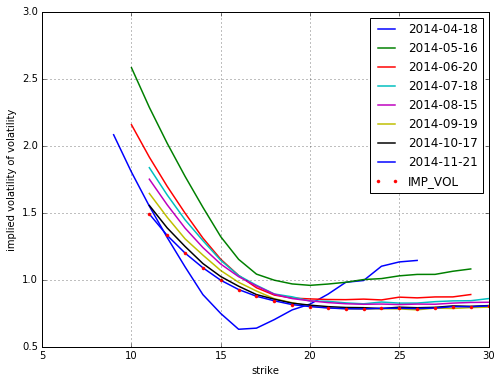

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
        # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=datetime.utcfromtimestamp(maturity/1000000000).date(), lw=1.5)
plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

In [16]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [17]:
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY            STRIKE                 
1397779200000000000 9.0      8.85  2.083386
                    10.0     7.85  1.804194
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184

In [18]:
group_data.index.levels

FrozenList([[1397779200000000000, 1400198400000000000, 1403222400000000000, 1405641600000000000, 1408060800000000000, 1411084800000000000, 1413504000000000000, 1416528000000000000], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

## Monte Carlo Simulation

Monte Carlo simulation is one of the most important algorithms in finance and numerical science in general. the Monte Carlo method can easily cope with high-dimensional problems where the complexity and computational demand, respectively, generally increase in linear fashion.
With the following examples we try to show different implementation strategies in <code>Python</code> and offers three different implementation approaches for a Monte Carlo-based valuation of a European option. The three approaches are:
* Pure Python
* Vectorized NumPy
* Fully Vectorized NumPy

The examples are again based on the model economy of Black-Scholes-Merton (1973), where the risky underlying (e.g., a stock price or index level) follows, under risk neutrality, a geometric Brownian motion with a stochastic differential equation (SDE), as in Equation 3-5.

**Equation 3-5**. _Black-Scholes-Merton (1973) stochastic differential equation_

$$ d S_{t} = rS_{t}dt + \sigma S_{t}dZ_{t} $$

**Equation 3-6**. _Euler discretization of SDE_

$$ S_{t} = S_{t-\Delta t} exp((r-\frac{1}{2}\sigma^{2})\Delta t + \sigma \sqrt{\Delta t}z_{t}) $$
The variable z is a standard normally distributed random variable, 0 < t < T, a (small enough) time interval. It also holds 0 < t ≤ T with T the final time horizon.

We parameterize the model with the values S0 = 100, K = 105, T = 1.0, r = 0.05, = 0.2.
Using the Black-Scholes-Merton formula as in Equation 3-1 and Example 3-1 from the previous example, we can calculate the exact option value as follows:

In [19]:
## from bsm_functions import bsm_call_value

S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.0213522351431763

To implement a Monte Carlo valuation of the European call option
> 1. Divide the time interval [0,T] in equidistant subintervals of length  t.
> 2. Start iterating i = 1, 2,…, I.
>> 1. For every time step t ∈ {  t, 2  t,…, T}, draw pseudorandom numbers z<sub>t</sub>(i).
>> 2. Determine the time T value of the index level ST(i) by applying the pseudo-random numbers time step by time step to the discretization scheme in Equation 3-6.
>> 3. Determine the inner value hT of the European call option at T as hT(ST(i)) = max(ST(i) – K,0).
>> 4. Iterate until i = I.
> 3. Sum up the inner values, average, and discount them back with the riskless short rate according to Equation 3-7.


Equation 3-7 provides the numerical Monte Carlo estimator for the value of the European call option.

**Equation 3-7**. _Monte Carlo estimator for European call option_

$$ C_{0} \approx \exp^{-rT} \frac{1}{I} \sum_{I}h_{T}(S_{T}(i))$$

### Pure Python

Example 3-2 translates the parametrization and the Monte Carlo recipe into pure Python. The code simulates 250,000 paths over 50 time steps.

**Example 3-2**. _Monte Carlo valuation of European call option with pure Python_

In [20]:
%run mcs_pure_python.py

European Option Value   7.999
Duration in Seconds  34.788


In [21]:
sum_val = 0.0
for path in S:
    # C-like iteration for comparison 
    sum_val += max(path[-1] - K, 0)
C0 = exp(-r * T) * sum_val / I
round(C0, 3)

7.999

### Vectorization with NumPy

<code>NumPy</code> provides a powerful multidimensional array class, called <code>ndarray</code>, as well as a comprehensive set of functions and methods to manipulate arrays and implement (complex) operations on such objects. From a more general point of view, there are two major benefits of using <code>NumPy</code>:
* Syntax
* Speed

The generally more compact syntax stems from the fact that <code>NumPy</code> brings powerful vectorization and broadcasting capabilities to <code>Python</code>. This is similar to having vector notation in mathematics for large vectors or matrices. 

$$ \vec v = \pmatrix {1 \\ 2 \\ \vdots \\100} $$



$$ \vec u = 2 \cdot \vec v = \pmatrix {2 \\ 4 \\ \vdots \\200}$$

In [22]:
v = range(1, 6)
print(v)

range(1, 6)


In [23]:
2 * v

TypeError: unsupported operand type(s) for *: 'int' and 'range'

In [24]:
2 * list(v)

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [25]:
import numpy as np

v = np.arange(1, 6)
v

array([1, 2, 3, 4, 5])

In [26]:
2*v

array([ 2,  4,  6,  8, 10])

This approach can be beneficially applied to the Monte Carlo algorithm. Example 3-3 provides the respective code, this time making use of <code>NumPy</code>’s vectorization capabilities.

**Example 3-3**. _Monte Carlo valuation of European call option with NumPy (first version)_

In [27]:
%run mcs_vector_numpy.py

European Option Value   8.037
Duration in Seconds   1.151


In [28]:
round(tpy/tnp1, 2)

30.23

> <center>**VECTORIZATION**</center>

> Using vectorization with <code>NumPy</code> generally results in code that is more compact, easier to read (and maintain), and faster to execute. All these aspects are in general important for financial applications.

### Full Vectorization with Log Euler Scheme

This version is completely additive, allowing for an implementation of the Monte Carlo algorithm without any loop on the <code>Python</code> level. 

**Example 3-4**. _Monte Carlo valuation of European call option with NumPy (second version)_

In [29]:
%run mcs_full_vector_numpy.py

European Option Value   8.166
Duration in Seconds   1.332


### Graphical Analysis

Let us have a graphical look at the underlying mechanics. First, we plot the first 10 simulated paths over all time steps. 

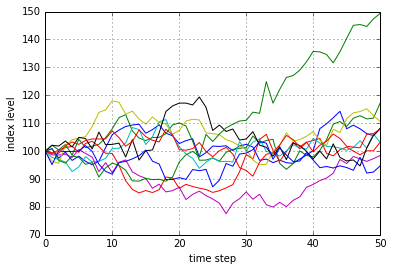

In [30]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Second, we want to see the frequency of the simulated index levels at the end of the simulation period. 

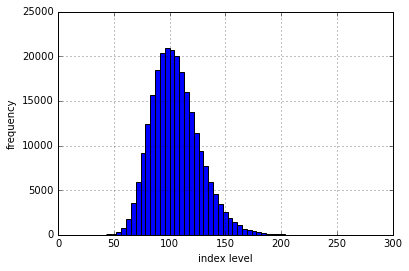

In [31]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

The same type of figure looks completely different for the option’s end-of-period (maturity) inner values.

(0, 50000)

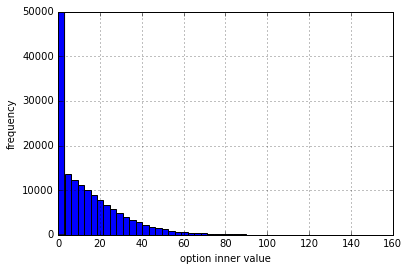

In [32]:
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)

In [33]:
sum(S[-1] < K)

133533

## Technical Analysis

Technical analysis based on historical price information is a typical task finance professionals and interested amateurs engage in. 

> In finance, technical analysis is a security analysis methodology for forecasting the direction of prices through the study of past market data, primarily price and volume.

> <div style="text-align: right">— Wikipedia </div>

Our object of study is the benchmark index Standard & Poor’s 500 (S&P 500), which is generally considered to be a good proxy for the _whole_ stock market in the United States. 

First we need the data to get started. 

In [35]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

> <center>**SCIENTIFIC AND FINANCIAL PYTHON STACK**</center>

> In addition to <code>NumPy</code> and <code>SciPy</code>, there are only a couple of important libraries that form the fundamental scientific and financial <code>Python</code> stack. Among them is <code>pandas</code>. Make sure to always have current (stable) versions of these libraries installed 

The sublibrary pandas_datareader.data contains the function DataReader, which helps with getting financial time series data from different sources and in particular from the popular Yahoo! Finance site. 

In [37]:
start='1/1/2000'
end='4/14/2014'
sp500 = web.DataReader('^GSPC', 'yahoo', start, end)
sp500.info()

ConnectionError: HTTPConnectionPool(host='ichart.finance.yahoo.com', port=80): Max retries exceeded with url: /table.csv?e=14&b=1&d=3&a=0&g=d&ignore=.csv&c=2000&f=2014&s=%5EGSPC (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x147e8a940>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

<code>DataReader</code> has connected to the data source via an Internet connection and has given back the time series data for the S&P 500 index, from the first trading day in 2000 until the end date. It has also generated automatically a time index with <code>Timestamp</code> objects.

In [ ]:
sp500['Close'].plot(grid=True, figsize=(8, 5))

The trend strategy we want to implement is based on both a two-month (i.e., 42 trading days) and a one-year (i.e., 252 trading days) trend (i.e., the moving average of the index level for the respective period). 

In [ ]:
sp500['42d'] = np.round(pd.rolling_mean(sp500['Close'], window=42), 2)
sp500['252d'] = np.round(pd.rolling_mean(sp500['Close'], window=252), 2)

In [ ]:
from pandas import Series
sp500['42d'] = np.round(Series.rolling(sp500['Close'], window=42, center=False).mean())
sp500['252d'] = np.round(Series.rolling(sp500['Close'], window=252, center=False).mean())

In [ ]:
sp500[['Close', '42d', '252d']].tail()

Second, the plotting of the new data.

In [ ]:
sp500[['Close', '42d', '252d']].plot(grid=True, figsize=(8, 5))

Our basic data set is mainly complete, such that we now can devise a rule to generate trading signals. The rule says the following:
* Buy signal (go long)- the 42d trend is for the first time SD points above the 252d trend.
* Wait (park in cash) - the 42d trend is within a range of +/– SD points around the 252d trend. 
* Sell signal (go short) - the 42d trend is for the first time SD points below the 252d trend.

In [ ]:
sp500['42-252'] = sp500['42d'] - sp500['252d'] 
sp500['42-252'].tail()

In [ ]:
sp500['42-252'].head()

To make it more formal, we again generate a new column for what we call a _regime_. We assume a value of 50 for the signal threshold:

In [ ]:
SD = 50
sp500['Regime'] = np.where(sp500['42-252'] > SD, 1, 0)
sp500['Regime'] = np.where(sp500['42-252'] < -SD, -1, sp500['Regime'])
sp500['Regime'].value_counts()

In [ ]:
sp500['Regime'].plot(lw=1.5)
plt.ylim([-1.1, 1.1])

Based on the respective regime, the investor either is long or short in the market (index) or parks his wealth in cash, which does not bear any interest. This simplified strategy allows us to work with market returns only. The investor makes the market return when he is long
(1), makes the negative market returns when he is short (–1), and makes no returns (0) when he parks his wealth in cash. We therefore need the returns first. 

In [ ]:
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

In [ ]:
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

In [ ]:
sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(8, 5))

> <center>**FINANCIAL TIME SERIES**</center>

> Whenever it comes to the analysis of financial time series, consider using <code>pandas</code>. Almost any time series-related problem can be tackled with this powerful library.